# Autograd Demo
This is a demo of my *autograd* repository. To shortly describe what it is:
- *autograd* is a automatic differentiation framework that allows for calculating the gradients of a wide range of mathematical expressions (not just neural networks)
- This can be used to for optimization by doing backpropagation
- It is basically a boiled down analog to pytorch and also follows pytorch's syntax 

In [1]:
import autograd
from autograd.optimizer import GD

import numpy as np
import torch
import math

import random
import time

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import pylab
plt.rcParams["figure.figsize"] = (10,10)

# Comparing autograd and PyTorch 
To introduce the API and to check how well *autograd* works we compute the gradient with respect to $x$ of the messy function 
$$f(x) := ((x-2)^{2/x}-1)^{x-1}$$
and compare it with the gradient PyTorch would give us. To run more gradient checking tests, you can run the **test.py** script located at "autogradengine/autograd/test.py".

In [2]:
def gradient_test_f(x):
    return ((x - 3.)**(2./x) - 1) ** (x - 1.)

# Compute gradient df/dx at x=1 using torch
torch_x = torch.Tensor([10.])
torch_x.requires_grad = True

torch_time = time.time()
torch_y = gradient_test_f(torch_x)
torch_y.backward()
torch_time = time.time() - torch_time

torch_grad = torch_x.grad

# Compute gradient df/dx at x=1 using autograd
autograd_x = autograd.Variable(10.)

autograd_time = time.time()
autograd_y = gradient_test_f(autograd_x)
autograd_y.backward()
autograd_time = time.time() - autograd_time

autograd_grad = autograd_x.grad

print(
    f"torch gradient {torch_grad.item():.5f} in {torch_time:.5f}s\nautograd gradient: {autograd_grad.item():.5f} in {autograd_time:.5f}s")
if math.isclose(torch_grad, autograd_grad, abs_tol=1e-5):
    print("\nThe packages agree!")

torch gradient -0.00129 in 0.00155s
autograd gradient: -0.00129 in 0.00057s

The packages agree!


# Simple Example: Minimizing Quadratic Function
As a first simple demo example, we use the autograd engine to solve the minimization problem
$$x^*=\text{argmin}\left[(x-2)^2+4x-2\right].$$

In [3]:
# Defining the function to be optimized
def f(x):
    return (x-2)**2 + 4*x - 2
    

# autograd.Module is analog to torch.nn.Module
class QuadrFuncMod(autograd.Module):
    def __init__(self, init):
        super(QuadrFuncMod, self).__init__()
        self.x = autograd.Variable(init)
    
    def forward(self):
        return f(self.x) 
    

# Iteratively computing forward pass, backward pass and then doing a gradient step
def perform_gd(initializations, lrs, epochs=100):
    n_runs = len(initializations)
    print(f"Performing GD for {n_runs} runs with different initializations:\n")
    
    func_value_history = []
    x_value_history = []
    
    for run in range(n_runs):
        print(f"\nStarting run {run} with x_0={initializations[run]}")
        func_value_history.append([])
        x_value_history.append([])
            
        module = QuadrFuncMod(initializations[run])
        optim = GD(params=module.collect_parameters(), lr=lrs[run])

        for epoch in range(epochs):
            
            x_value_history[run].append(float(module.x.value.squeeze()))

            # Set the gradient of all parameters to zero
            optim.zero_grad()

            # Forward pass constructs computational graph dynamically
            func_value = module.forward()

            # Like in pytorch: simply call backward pass on optimization criterion 
            # This performs backpropagation through the computational graph
            func_value.backward()  

            # Optimizer reads out gradients of all parameters and performs on gradient step
            optim.step()

            func_value_history[run].append(func_value.value.squeeze())
            if epoch % 25 == 0:
                print(f"epoch: {epoch} | x: {module.x.value} | f(x): {func_value.value}")
            
    return np.array(x_value_history), np.array(func_value_history)

In [4]:
# Perform optimization
initializations = [-3, 4]
learning_rates = [0.1, 0.8]
x_value_history, func_value_history = perform_gd(initializations, learning_rates)

Performing GD for 2 runs with different initializations:


Starting run 0 with x_0=-3
epoch: 0 | x: [[-2.4]] | f(x): [[11.]]
epoch: 25 | x: [[-0.00906694]] | f(x): [[2.00012845]]
epoch: 50 | x: [[-3.42539446e-05]] | f(x): [[2.]]
epoch: 75 | x: [[-1.29407744e-07]] | f(x): [[2.]]

Starting run 1 with x_0=4
epoch: 0 | x: [[-2.4]] | f(x): [[18.]]
epoch: 25 | x: [[6.82326913e-06]] | f(x): [[2.]]
epoch: 50 | x: [[-1.93985499e-11]] | f(x): [[2.]]
epoch: 75 | x: [[-2.26826369e-17]] | f(x): [[2.]]


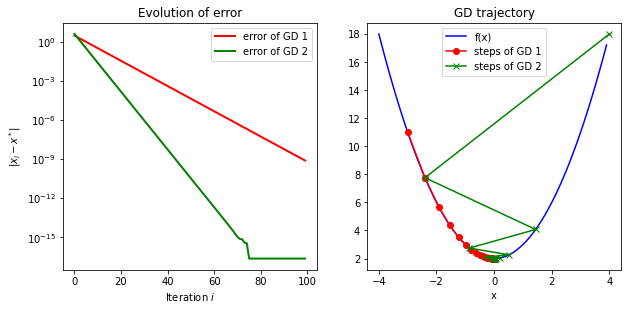

In [5]:
fig = plt.figure()

# plot GD trajectory
ax2 = fig.add_subplot(2, 2, 2)
x_range = np.arange(-4, 4, .1)
ax2.plot(x_range, f(x_range), label='f(x)', color='b')
ax2.plot(x_value_history[0], func_value_history[0], '-o', color='r', label='steps of GD 1')
ax2.plot(x_value_history[1], func_value_history[1], '-x', color='g', label='steps of GD 2')

plt.legend()
plt.title("GD trajectory")
plt.xlabel("x")

# plot error 
x_star = 0  # analytical solution to minization problem
error = np.abs(x_value_history - x_star)
ax1 = fig.add_subplot(2, 2, 1)
line, = ax1.plot(error[0], color='r', lw=2, label='error of GD 1')
line, = ax1.plot(error[1], color='g', lw=2, label='error of GD 2')
ax1.set_yscale('log')
plt.title('Evolution of error')
plt.xlabel('Iteration $i$')
plt.ylabel('$|x_i-x^*|$')
plt.legend()

pylab.show()

The visualization shows that the algorithm converged exponentially and converges to the global optimum, which was expected for a quadratic function.

# Multivariate Minimization
In the follwing, the autograd engine is applied to a multivariate minimization problem. The basic principle is the same as in the previous example, however here the optimization regime is $\mathbb R^2$, as we optimize over $x$ and $y$. The minimization problem will be 
$$x^*, y^* = \text{argmin}\left[{((x^2+y^3)-1) \cdot \exp{(-0.5{(x^2+y^2)})}}\right],$$
which is non-convex.

In [6]:
def z_func(x,y):
    return -(1-(x**2+y**3))*np.exp(-(x**2+y**2)/2)
    

class MulVariableMod(autograd.Module):
    def __init__(self, init_x, init_y):
        super(MulVariableMod, self).__init__()
        self.x = autograd.Variable(init_x) 
        self.y = autograd.Variable(init_y) 
        self.exp = autograd.Exp()  # autograd supports a range of nonlinearities

        print(f"\nStarting initialization: x={self.x.value.squeeze()}, y={self.y.value.squeeze()}")
        self.params = self.collect_parameters()
    
    def forward(self):
        return -(1-(self.x**2+self.y**3))*self.exp(-(self.x**2+self.y**2)/2)
    
    
def perform_2d_gd(initializations, epochs=15):
    n_runs = len(initializations)
    print(f"Performing GD for {n_runs} runs with different initializations:")

    # initializations have shape [runs, 2]
    func_value_history = []  # collecting lists should have shape [runs, epochs] after loop 
    x_value_history = []
    y_value_history = []
    
    for run in range(n_runs):
        module = MulVariableMod(init_x=initializations[run][0], 
                                init_y=initializations[run][1])
        optim = GD(params=module.collect_parameters(), lr=0.3)
        
        func_value_history.append([])
        x_value_history.append([])
        y_value_history.append([])

        for epoch in range(epochs):
            x_value_history[run].append(float(module.x.value))
            y_value_history[run].append(float(module.y.value)) 

            optim.zero_grad()
            func_value = module.forward()
            func_value.backward()
            optim.step()

            func_value_history[run].append(func_value.value)
            if epoch % 5 == 0:
                print(f"   epoch: {epoch} | x: {module.x.value.squeeze():.3f} | y: {module.y.value.squeeze():.3f} | f(x): {func_value.value.squeeze():.3f}")            
    return np.array(x_value_history), np.array(y_value_history), np.array(func_value_history)

In [7]:
# Perform optimization on multiple starting initializations
initializations = [[0.5, 1.8],
                  [-2, -2], 
                  [-2, 2], 
                  [1.6, -0.1]]
x_value_history, y_value_history, func_value_history = perform_2d_gd(initializations, epochs=15)

Performing GD for 4 runs with different initializations:

Starting initialization: x=0.5, y=1.8
   epoch: 0 | x: 0.581 | y: 1.770 | f(x): 0.888
   epoch: 5 | x: 1.037 | y: 1.426 | f(x): 0.686
   epoch: 10 | x: 0.903 | y: 0.674 | f(x): 0.298

Starting initialization: x=-2.0, y=-2.0
   epoch: 0 | x: -1.923 | y: -2.011 | f(x): -0.092
   epoch: 5 | x: -1.272 | y: -1.979 | f(x): -0.323
   epoch: 10 | x: -0.135 | y: -1.608 | f(x): -1.322

Starting initialization: x=-2.0, y=2.0
   epoch: 0 | x: -2.099 | y: 2.055 | f(x): 0.201
   epoch: 5 | x: -2.425 | y: 2.249 | f(x): 0.079
   epoch: 10 | x: -2.606 | y: 2.362 | f(x): 0.043

Starting initialization: x=1.6, y=-0.1
   epoch: 0 | x: 1.541 | y: -0.115 | f(x): 0.431
   epoch: 5 | x: 0.397 | y: -0.209 | f(x): -0.259
   epoch: 10 | x: 0.000 | y: -0.100 | f(x): -0.994


Function and plot taking from here: [Link](https://glowingpython.blogspot.com/2012/01/how-to-plot-two-variable-functions-with.html)

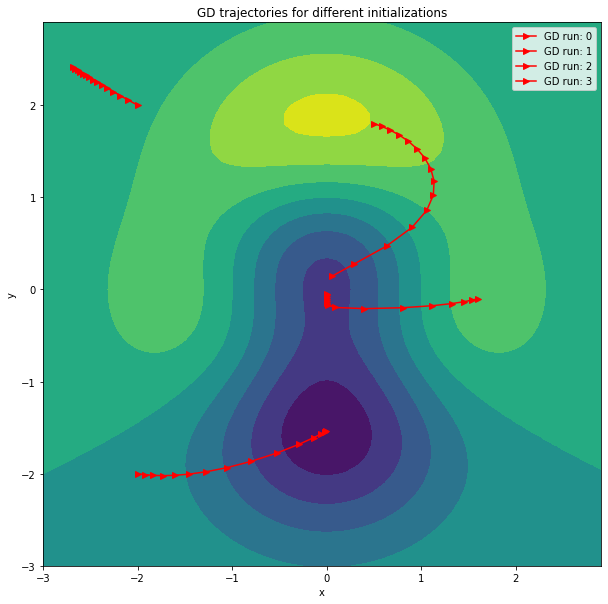

In [8]:
# Plot the GD trajectories
x = np.arange(-3.0,3.0,0.1)
y = np.arange(-3.0,3.0,0.1)
[X, Y] = np.meshgrid(x, y)
fig, ax = plt.subplots(1, 1)
Z = z_func(X,Y)
ax.contourf(X, Y, Z)  
ax.set_xlabel('x')
ax.set_ylabel('y')
for run in range(x_value_history.shape[0]):
    plt.plot(x_value_history[run], y_value_history[run], '->', color='r', label=f'GD run: {run}')
plt.title("GD trajectories for different initializations")
plt.legend()
plt.show()

We can nicely see that the GD trajectories are orthogonal to the contour lines. Furthermore, not all runs converge to the global minimum, which is due to the the loss function not being convex.

# Perceptron

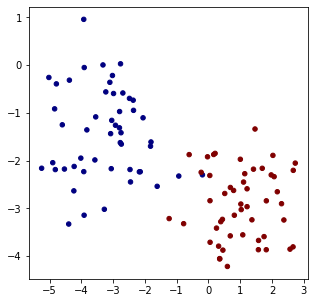

In [9]:
# load simple two class dataset
from sklearn.datasets import make_blobs

x_data, y_data = make_blobs(n_samples=100, centers=2, n_features=2, center_box=(-4, 4))
y_data = 2*y_data - 1
plt.figure(figsize=(5,5))
plt.scatter(x_data[:,0], x_data[:,1], c=y_data, s=20, cmap='jet')
plt.show()

In [10]:
dataset = autograd.nn.Dataset(x_data.reshape(-1 , 2, 1), y_data.reshape(-1, 1, 1))
perceptron = autograd.nn.Perceptron(output_size=1, input_size=2)
optimizer = GD(params=perceptron.collect_parameters(), lr=0.4)
mseloss = autograd.MSELoss()

AttributeError: module 'autograd' has no attribute 'nn'

In [11]:
# Train the Perceptron
epochs = 400
loss_hist = []

for epoch in range(epochs):
    optimizer.zero_grad()
    loss = perceptron.forward_dataset(dataset, mseloss)
    loss.backward()
    optimizer.step()

    loss_hist.append(loss.value.item())
    if epoch % 100 == 0:
        print(f"epoch: {epoch} | loss:{loss.value.squeeze():.4f}")

#plt.plot(loss_ev)
#plt.show()
plt.show()

NameError: name 'optimizer' is not defined

In [12]:
w, b = perceptron.linear.weight.value.squeeze(), perceptron.linear.bias.value.squeeze()

NameError: name 'perceptron' is not defined

NameError: name 'w' is not defined

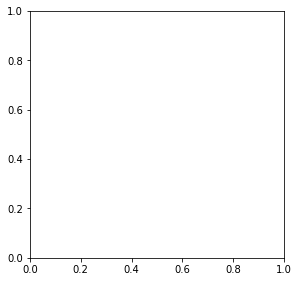

In [13]:
fig = plt.figure()
ax1 = fig.add_subplot(2, 2, 1)

# plot learnt decision boundary
x_range = np.arange(min(x_data[:,1]), max(x_data[:,0]))
decision_boundary = -(w[0]/w[1])*x_range - b/w[1]
ax1.scatter(x_data[:,0], x_data[:,1], c=y_data, s=20, cmap='jet')
ax1.plot(decision_boundary, label='Decision boundary', color='g')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

# plot loss
ax2 = fig.add_subplot(2, 2, 2)
ax2.plot(loss_hist, label='MSE loss history')
plt.legend()
plt.xlabel('iterations')

plt.show()